In [73]:
import re
import numpy as np
import pandas as pd
import tabata as tbt
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline

import Projet_rectangularisation_vols as m2d 

%reload_ext autoreload
%autoreload 2

In [74]:
# Chargement des données.
datadir = "../Data/cleaned/"
final_file = datadir + "AFL1EB_cleaned_final.h5"
norm_file = datadir + "AFL1EB_normed_alt.h5"
ds = tbt.Opset(final_file)
ds

OPSET '../Data/cleaned/AFL1EB_cleaned_final.h5' de 47 signaux.
        position courante : sigpos  = 0
        variable courante : colname = ALT[m]
        phase surlignée   : phase   = None

## Création d'une série d'instants de changement de phase par vol.

In [75]:
df = ds[23]
y = df['ALT[m]'].values
n = len(y)
t = np.arange(0,n)


In [76]:
df.index.name

'record_28'

In [77]:
t1 = np.max(np.argwhere((y<y[0]+10) & (t<n/3)))
t1

1304

In [78]:
t4 = np.min(np.argwhere((y<y[-1]+10) & (t>2*n/3)))
t4

5879

In [79]:
dy = np.append(np.diff(y),0)
k = 3
dyc = np.convolve(dy,np.ones(2*k+1)/(2*k+1))
dyc = dyc[k:-k]
mx = np.max(y)
tx = np.argwhere(y==mx)
txm = (tx[0]+tx[-1])/2
t2 = np.min(np.argwhere((y>mx-mx/10) & (dyc<2.5) & (t>t1) & (t<txm)))
t3 = np.max(np.argwhere((y>mx-mx/10) & (dyc>-2.5) & (t<t4) & (t>txm)))

In [80]:
t1,t2,t3,t4,txm

(1304, 2311, 3660, 5879, array([3106.]))

In [81]:
t1,t2,t3,t4

(1304, 2311, 3660, 5879)

In [82]:
L = []
for i,df in enumerate(ds):
    t1,t2,t3,t4 = m2d.compute_points(df)
    
    L.append({'record' : i, 'points' : np.array([t1,t2,t3,t4])})
    

In [83]:
P = m2d.compute_all_sizes(ds)
NL = P.max(axis=0)

In [84]:
import numpy as np
import pandas as pd
import re


# Initialisation des dictionnaires
R = {c: [] for c in cols}
rec = []

# Boucle sur les DataFrames
for df in ds:
    rec.append(df.index.name)
    I = m2d.compute_points(df)
    I = [0] + list(I) + [len(df) - 1]  # Ajout des bornes

    for V, C in zip(cols, df.columns):
        x = df[C].values

        # Convertir booléens en float si nécessaire
        if df[C].dtype == bool:
            x = x.astype(float)

        # Normalisation
        x0, x1 = np.max(x), np.min(x)
        if x0 == x1:  # Éviter une division par zéro
            xn = np.zeros_like(x)
        else:
            xn = (x - x0) / (x1 - x0)

        # Initialisation de l'interpolation
        Y = np.array([xn[0]])

        for i in range(len(I) - 1):
            t0 = df.index[I[i]].to_numpy().astype('int64') // 10**9
            t1 = df.index[I[i+1]].to_numpy().astype('int64') // 10**9

            # Vérifier que `NL[i]` existe
            if i >= len(NL):
                continue  # Évite les erreurs d'index

            t = pd.date_range(start=pd.to_datetime(t0, unit='s'),
                              end=pd.to_datetime(t1, unit='s'),
                              periods=NL[i])

            t_numeric = t.astype('int64') // 10**9  # Conversion en timestamps
            xp = df.index[I[i]:I[i+1]].to_numpy().astype('int64') // 10**9
            y = np.interp(t_numeric, xp, xn[I[i]:I[i+1]])

            Y = np.hstack([Y, y[1:]])

        R[V].append(Y)

# Transformation en DataFrame
for V in cols:
    R[V] = pd.concat([pd.Series(r) for r in R[V]], axis=1)
    R[V].columns = rec


In [85]:
R = m2d.frust_phase_nrm(ds, NL)
np.sum(NL)
m2d.NORM_DATA = m2d.norm_data1
F = m2d.frust_nrm(ds,np.sum(NL))

## Calcul de l'erreur de synchronisation.

In [86]:
dsf = np.mean(F['ALT'].max(axis=1)-F['ALT'].min(axis=1))
dsp = np.mean(R['ALT'].max(axis=1)-R['ALT'].min(axis=1))
g = (dsf-dsp)/dsf
print("Erreur de synchronisation:")
print(f"  * fruste    = {dsf:.2f}")
print(f"  * par phase = {dsp:.2f},")
print(f"Gain relatif  = {g:.2f}")

Erreur de synchronisation:
  * fruste    = 0.49
  * par phase = 0.12,
Gain relatif  = 0.76


In [87]:
def global_synch_error(R):
    """
    GLOBAL_SYNC_RELATIVE_ERROR - Calcul de l'erreur globale de synchronisation par colonne.

    * F : calcul fruste.
    * R : calcul de comparaison.
    """
    # Nobre de points pour le rééchantillonnage fruste.
    cols = list(R.keys())
    N = len(R[cols[0]])
    F = m2d.frust_nrm(ds,N)
    E = pd.DataFrame(index=R.keys(),columns=['FRN','ERR','RG'],dtype=float)
    for col in cols:
        dsf = np.mean(F[col].max(axis=1)-F[col].min(axis=1))
        dsp = np.mean(R[col].max(axis=1)-R[col].min(axis=1))
        E.loc[col,'FRN'] = dsf
        E.loc[col,'ERR'] = dsp
        E.loc[col,'RG'] = (dsf-dsp)/dsf
    return E

In [88]:
global_synch_error(R)

,FRN,ERR,RG
ALT,0.494661,0.121050,0.755287
Tisa,0.496334,0.120676,0.756864
TAS,0.404824,0.133140,0.671116
Vz,0.422180,0.249000,0.410204
Masse,0.112770,0.208736,-0.850994
F,0.366083,0.200518,0.452261
CR,0.688492,0.435931,0.366832


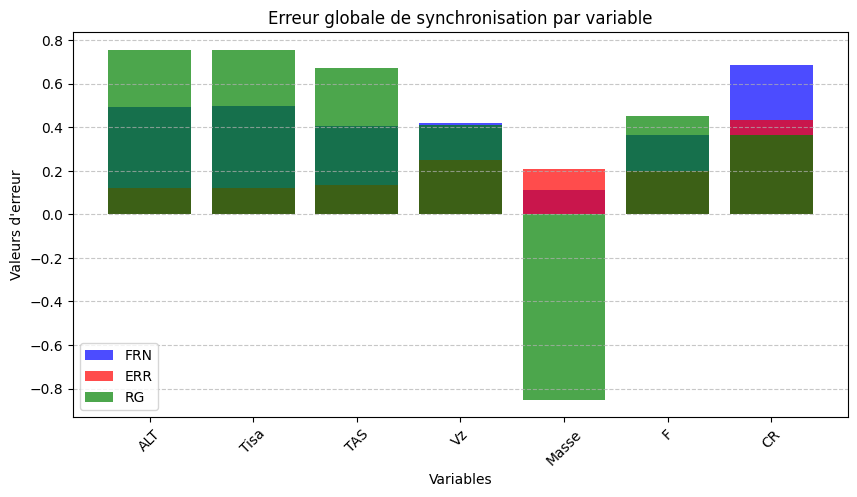

In [89]:
import matplotlib.pyplot as plt

error_results = global_synch_error(R)

# Création de la figure
plt.figure(figsize=(10, 5))

# Tracer les barres pour chaque métrique
plt.bar(error_results.index, error_results['FRN'], label='FRN', alpha=0.7, color='blue')
plt.bar(error_results.index, error_results['ERR'], label='ERR', alpha=0.7, color='red')
plt.bar(error_results.index, error_results['RG'], label='RG', alpha=0.7, color='green')

# Ajouter labels et titre
plt.xlabel("Variables")
plt.ylabel("Valeurs d'erreur")
plt.title("Erreur globale de synchronisation par variable")
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Affichage du graphique
plt.show()


## Erreur de reconstruction.

In [90]:
import numpy as np
import pandas as pd

def global_reconst_error(ds, R):

    cols = list(R.keys())
    errors = {V: [] for V in cols}

    for i, df in enumerate(ds):
        time_col = df.index  
        for V, C in zip(cols, df.columns):
            x = df[C].values
            xn = m2d.NORM_DATA(x)  
            if time_col.name not in R[V].columns:
                continue  

            y = R[V][time_col.name].values  # Données reconstruites
            yn = np.interp(time_col, R[V].index, y)  
            
            errors[V].append(np.mean(np.abs(xn - yn)))  # Calcul de l'erreur moyenne absolue

    return {V: np.mean(errors[V]) for V in cols if errors[V]}  


In [91]:
global_reconst_error(ds,R)

{'ALT': 0.5784921804402381,
 'Tisa': 0.5787654197837979,
 'TAS': 0.6563118103727508,
 'Vz': 0.11668667885552594,
 'Masse': 0.43871561273987025,
 'F': 0.11524465154441554,
 'CR': 0.4118690247261505}

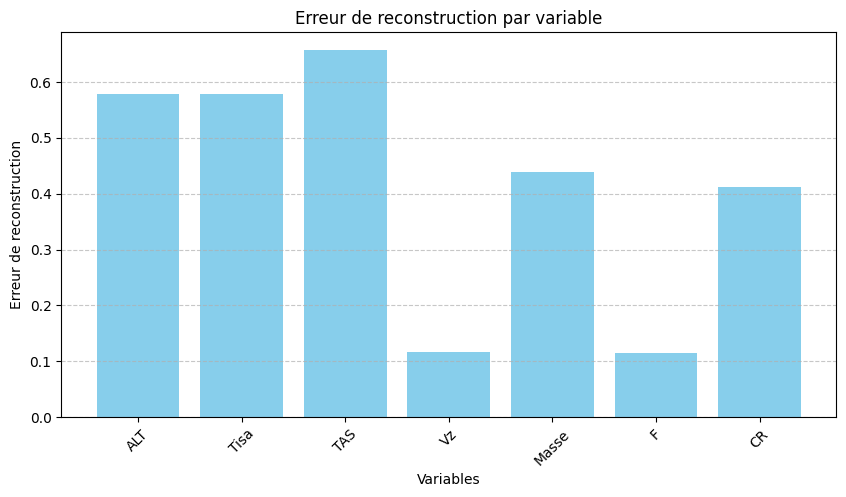

In [92]:
import matplotlib.pyplot as plt

error_results = global_reconst_error(ds, R)

plt.figure(figsize=(10, 5))
plt.bar(error_results.keys(), error_results.values(), color='skyblue')
plt.xlabel("Variables")
plt.ylabel("Erreur de reconstruction")
plt.title("Erreur de reconstruction par variable")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
